### CNN
### LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pytorch 사용시 gpu 확인
import torch
print(torch.cuda.is_available())

# Tensorflow gpu 확인
import tensorflow
print(tensorflow.config.list_physical_devices('GPU'))

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional 
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [4]:
plt.rcParams['font.size'] = 12
sns.set_style('dark')
warnings.filterwarnings('ignore')

In [5]:
image_path = 'drive/MyDrive/extract_raw_data/flickr8k/Images'

In [6]:
data = pd.read_csv('drive/MyDrive/extract_raw_data/flickr8k/captions.txt')
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [7]:
def read_image(path, img_size=224):
  img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/225

  return img


In [8]:
def display_images(temp_df):
  temp_df = temp_df.reset_index(drop=True)
  plt.figure(figsize=(20, 20))
  n = 0
  for i in range(15):
    n += 1
    plt.subplot(5, 5, n)
    plt.subplots_adjust(hspace=0.7, wspace=0.3)
    image = read_image(f'drive/MyDrive/extract_raw_data/flickr8k/Images/{temp_df.image[i]}')

    plt.imshow(image)
    plt.title('\n'.join(wrap(temp_df.caption[i], 20)))
    plt.axis('off')

In [9]:
print(data.sample(15))

                           image  \
18119  2993167197_e5d0a73530.jpg   
31893  3582920844_2742804f3d.jpg   
20892  3136404885_f4d8f1d15a.jpg   
7615   2318659263_c24005a5cb.jpg   
25023  3312779887_7682db7827.jpg   
25194  3320356356_1497e53f80.jpg   
17878  2978271431_f6a7f19825.jpg   
21532  3167379087_927ff05a35.jpg   
23033  3227111573_c82f7d68b1.jpg   
24612  3290105461_7590f23371.jpg   
30708  3535084928_858544f49a.jpg   
3210   1643915227_9f48068772.jpg   
5106    210686241_b8e069fff3.jpg   
12904  2662537919_18a29fca8a.jpg   
34682  3701544312_b2e4e9813d.jpg   

                                                 caption  
18119  The man is wearing an orange uniform and holdi...  
31893                            A person in the water .  
20892  Two men walking in front of a grafitti image o...  
7615        A fluffy white dog running across the snow .  
25023  A snowboarder is performing a stunt in front o...  
25194  The man in the blue shirt climbs a large rock ...  
17878  Rac

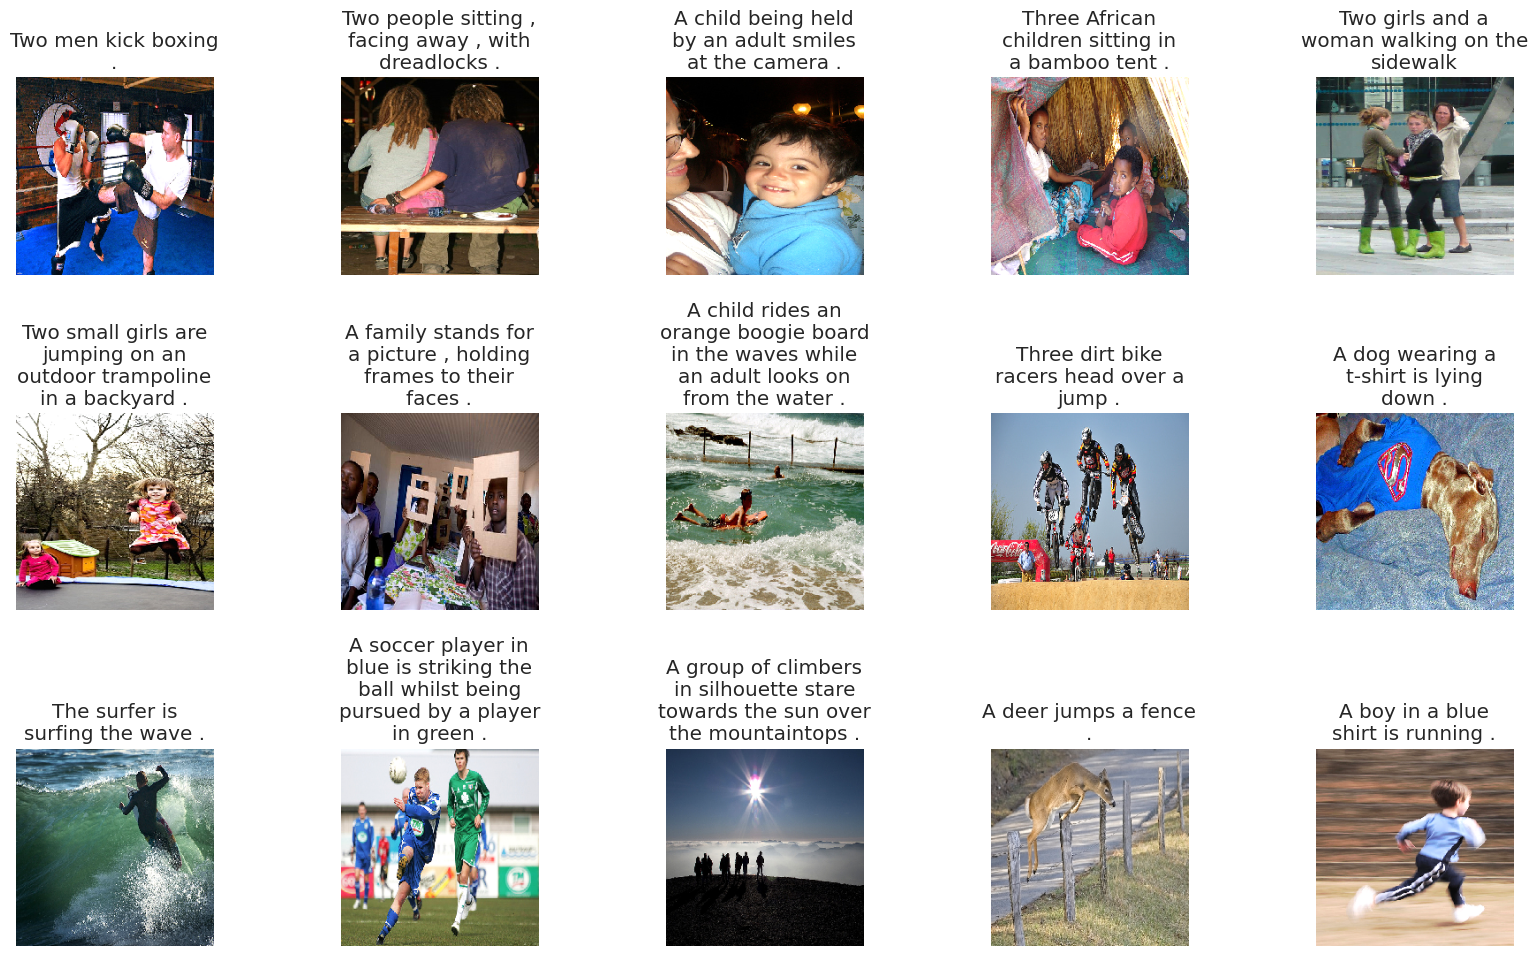

In [10]:
display_images(data.sample(15))

In [10]:
def text_preprocessing(data):
  data['caption'] = data['caption'].apply(lambda x: x.lower())
  data['caption'] = data['caption'].apply(lambda x: x.replace('[^A-Za-z]', ''))
  data['caption'] = data['caption'].apply(lambda x: x.replace('\s+', ' '))
  data['caption'] = data['caption'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>1]))
  data['caption'] = 'startseq ' + data['caption'] + ' endseq'
  return data

### Preprocessed Text

In [11]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

print(vocab_size)
print(max_length)

8485
34


In [13]:
images = data['image'].unique().tolist()
print('images\n',images)
nimages = len(images)
print('nimages', nimages)

split_index = round(0.85 * nimages)
print('split_index', split_index)
train_images = images[:split_index]
val_images = images[split_index:]

images
 ['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg', '1007320043_627395c3d8.jpg', '1009434119_febe49276a.jpg', '1012212859_01547e3f17.jpg', '1015118661_980735411b.jpg', '1015584366_dfcec3c85a.jpg', '101654506_8eb26cfb60.jpg', '101669240_b2d3e7f17b.jpg', '1016887272_03199f49c4.jpg', '1019077836_6fc9b15408.jpg', '1019604187_d087bf9a5f.jpg', '1020651753_06077ec457.jpg', '1022454332_6af2c1449a.jpg', '1022454428_b6b660a67b.jpg', '1022975728_75515238d8.jpg', '102351840_323e3de834.jpg', '1024138940_f1fefbdce1.jpg', '102455176_5f8ead62d5.jpg', '1026685415_0431cbf574.jpg', '1028205764_7e8df9a2ea.jpg', '1030985833_b0902ea560.jpg', '103106960_e8a41d64f8.jpg', '103195344_5d2dc613a3.jpg', '103205630_682ca7285b.jpg', '1032122270_ea6f0beedb.jpg', '1032460886_4a598ed535.jpg', '1034276567_49bb87c51c.jpg', '104136873_5b5d41be75.jpg', '1042020065_fb3d3ba5ba.jpg', '1042590306_95dea0916c.jpg', '1045521051_1

In [14]:
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train

,image,caption
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up se...
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden play...
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to he...
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into ...
...,...,...
34380,3688839836_ba5e4c24fc.jpg,startseq woman is holding out peace sign durin...
34381,3688839836_ba5e4c24fc.jpg,startseq woman wearing red scarf raises her ha...
34382,3688839836_ba5e4c24fc.jpg,startseq people in orange shirts marching down...
34383,3688839836_ba5e4c24fc.jpg,startseq the woman in the red shirt is holding...


In [15]:
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

'''
texts_to_sequences : 단어들을 숫자 형태의 sequence로 변환해줌
'''
tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [16]:
model = DenseNet201()
fe = Model(inputs = model.input, outputs = model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
  img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
  img = img_to_array(img)
  img = img/225
  img = np.expand_dims(img, axis=0)
  feature = fe.predict(img, verbose=0)
  features[image] = feature

100%|██████████| 8091/8091 [43:18<00:00,  3.11it/s]


In [17]:
class CustomDataGenerator(Sequence):
  def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, vocab_size, max_length, features, shuffle=True):
    self.df = df.copy()
    self.X_col = X_col
    self.y_col = y_col
    self.directory = directory
    self.batch_size = batch_size
    self.tokenizer = tokenizer
    self.vocab_size = vocab_size
    self.max_length = max_length
    self.features = features
    self.shuffle = shuffle
    self.n = len(self.df)

  def on_epoch_end(self):
    if self.shuffle:
      self.df = self.df.sample(frac=1).reset_index(drop=True)

  def __len__(self):
    return self.n // self.batch_size

  def __getitem__(self, index):
    batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
    X1, X2, y = self.__get_data(batch)
    return (X1, X2), y
  
  def __get_data(self, batch):
    X1, X2, y = list(), list(), list()
    images = batch[self.X_col].tolist()

    for image in images:
      feature = self.features[image][0]
      captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()

      for caption in captions:
        seq = self.tokenizer.texts_to_sequences([caption])[0]

        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
          out_seq = to_categorical([out_seq], num_classes = self.vocab_size)[0]
          
          X1.append(feature)
          X2.append(in_seq)
          y.append(out_seq)

    X1, X2, y = np.array(X1), np.array(X2), np.array(y)

    return X1, X2, y      

### Modeling
> The image embedding representations are concatenated with the first word of sentence 
i.e. startseq and passed to the LSTM network

> The LSTM network starts generating words after each input thus forming a sentence at the end 

In [19]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256, ))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')


In [20]:
from tensorflow.keras.utils import plot_model

### Model Modification
> A slight change has been made int the original model architecture to push the performance.
The image featrue embeddings are added to the output of the LSTMs and then passed on to the fully connected layers.

> This slightly improves the performance of the model originally proposed back in 2014: **Show and Tell: A Neural Image Caption Generator**

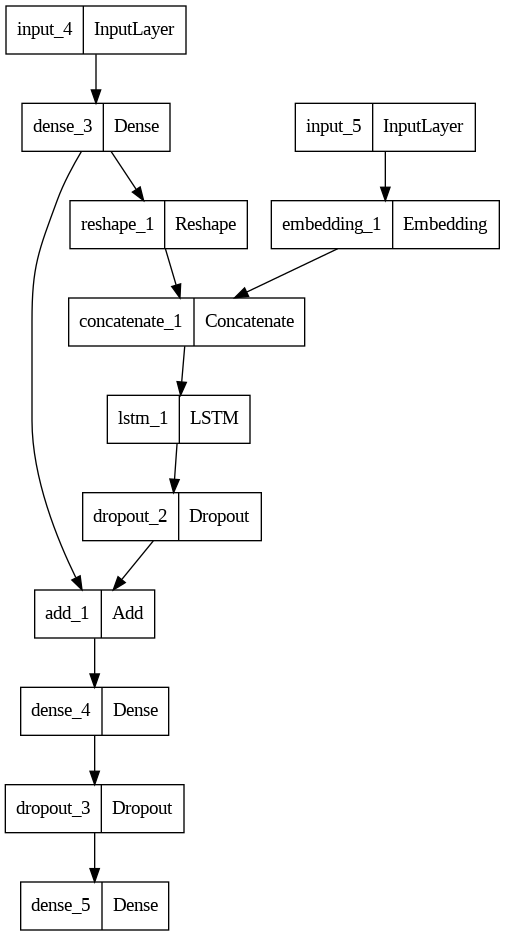

In [21]:
plot_model(caption_model)

In [22]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          491776      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

In [23]:
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path, tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

In [24]:
model_name = 'model.h5'
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', mode='min', save_bset_only=True, verbose=1)
earlystopping = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

In [25]:
history = caption_model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1165
Epoch 1: saving model to model.h5
537/537 [==============================] - 281s 511ms/step - loss: 5.1165 - val_loss: 4.2366 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.1769
Epoch 2: saving model to model.h5
537/537 [==============================] - 75s 139ms/step - loss: 4.1769 - val_loss: 3.9084 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9029
Epoch 3: saving model to model.h5
537/537 [==============================] - 75s 139ms/step - loss: 3.9029 - val_loss: 3.7611 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7392
Epoch 4: saving model to model.h5
537/537 [==============================] - 61s 114ms/step - loss: 3.7392 - val_loss: 3.6797 - lr: 0.0010
Epoch 5/50
537/537 [==============================] - ETA: 0s - loss: 3.6204
Epoch 5: saving model to model.h5
537/537 [===============

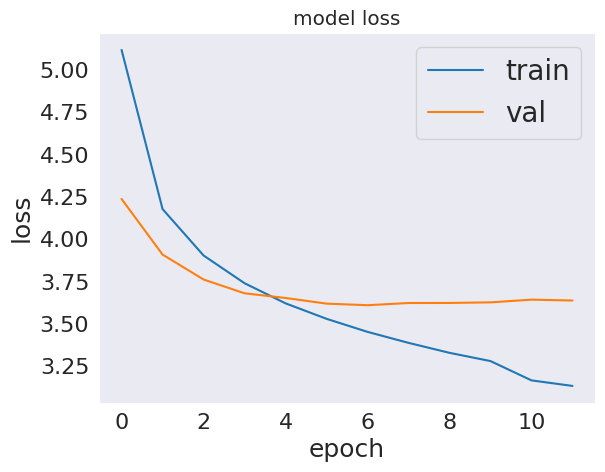

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.legend(['train', 'val'], loc='best', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [29]:
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [28]:
def predict_caption(model, image, tokenizer, max_length, features):
  feature = features[image]
  in_text = 'startseq'
  
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], max_length)

    y_pred = model.predict([feature, sequence])
    y_pred = np.argmax(y_pred)

    word = idx_to_word(y_pred, tokenizer)

    if word is None: 
      break
    in_text += ' ' + word

    if word == 'endseq':
      break

  return in_text

### Taking 15 Random Samples for Caption Prediction

In [ ]:
samples = test.sample(15)
sample.reset_index(drop=True, inplace=True)

In [ ]:
for index, record in samples.iterrows():
  img = load_img(os.path.join(image_path, record['image']), target_size=(224, 224))
  img = img_to_array(img)
  img = img/225

  caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
  samples.loc[index, 'caption'] = caption

In [ ]:
display_images(samples)

### Conclusion
> This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel attention model training and BLEU Scroe assessment will be performed.